In [1]:
import sys
sys.path.append("../../")

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

from benchmarks.rover import Rover

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}
SEED = 42
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define problem
# problem = BraninCurrin(negate=True).to(**tkwargs)
problem = GMM(negate=True).to(**tkwargs)
# problem.ref_point = torch.tensor([-250., -10.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

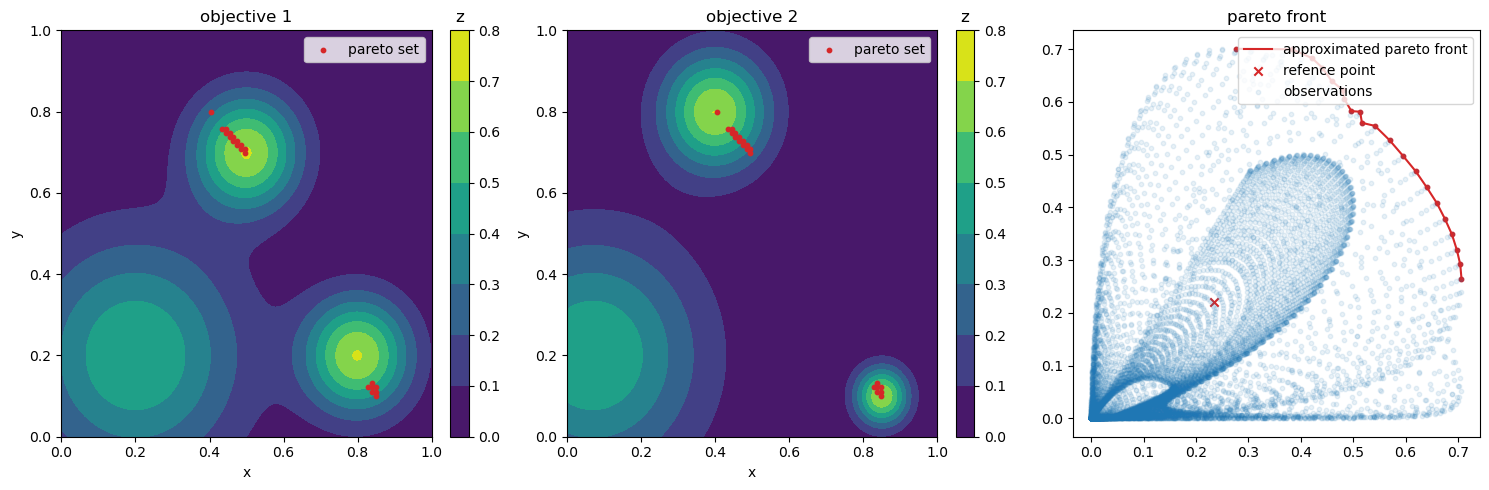

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

In [7]:
from optimizers.mbore.mbore_mdre_ei_aux_var_001 import MBORE_MDRE_EI_AUX_VAR_001
from optimizers.mbore.mbore_mdre_ei_rf_aux import MBORE_MDRE_EI_RF_AUX

In [8]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.3, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    # ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), s=10, color='k', label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

In [9]:
x_obs = init_x
y_obs = init_y

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(100, 100, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

2024-06-03 22:55:09,520 | optimizers.mbore.mbore_mdre_ei_rf_aux


Iteration 0


100%|██████████| 1000/1000 [00:01<00:00, 570.21it/s]
2024-06-03 22:55:12,168 | Model fitting takes 2.64s
2024-06-03 22:55:12,251 | Optimizing the acquisition function takes 0.08s


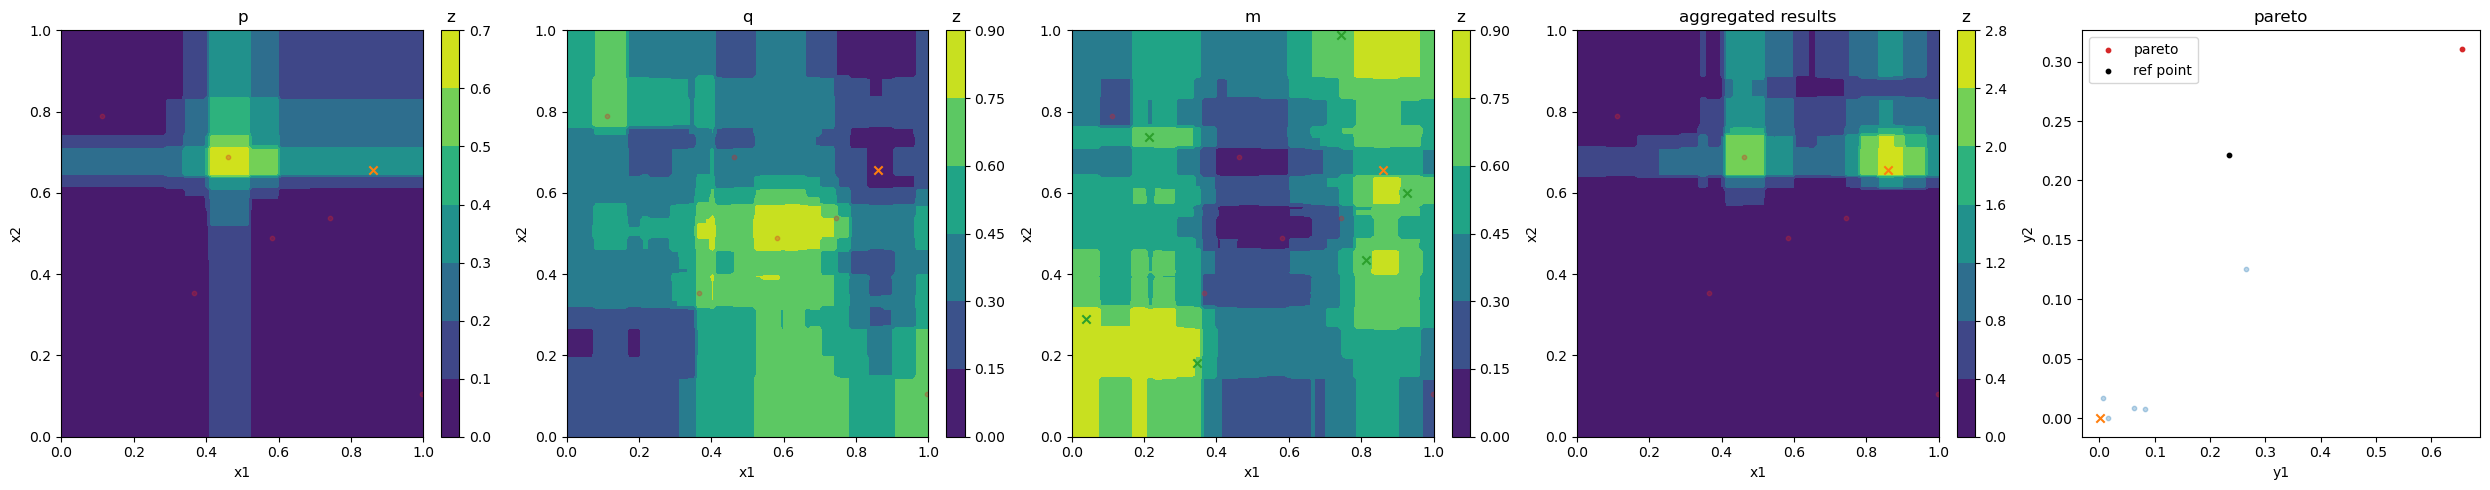

Iteration 1


100%|██████████| 1000/1000 [00:01<00:00, 607.47it/s]
2024-06-03 22:55:15,443 | Model fitting takes 2.24s
2024-06-03 22:55:15,521 | Optimizing the acquisition function takes 0.08s


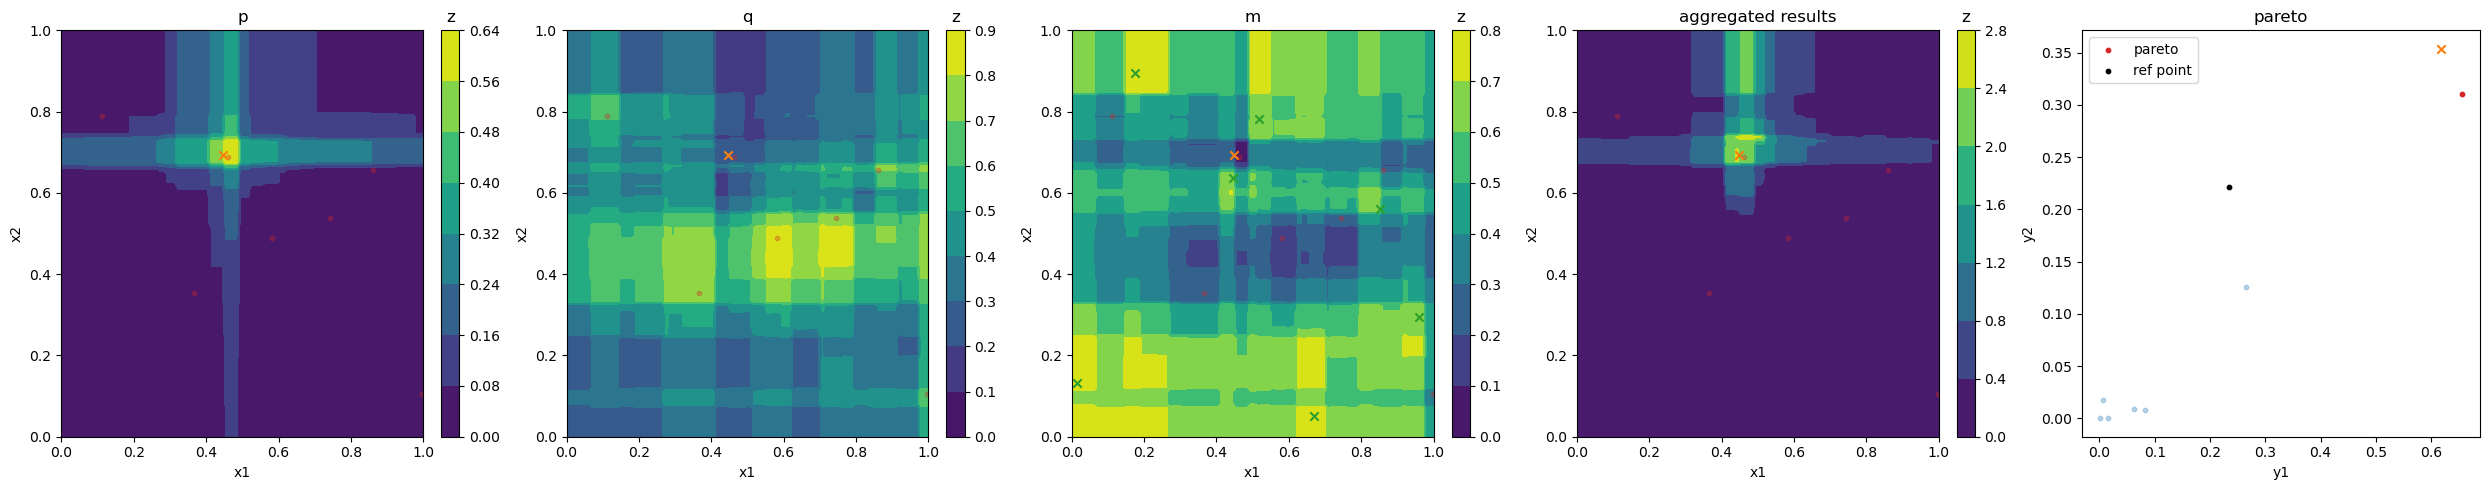

Iteration 2


100%|██████████| 1000/1000 [00:01<00:00, 594.65it/s]
2024-06-03 22:55:18,908 | Model fitting takes 2.30s
2024-06-03 22:55:18,992 | Optimizing the acquisition function takes 0.08s


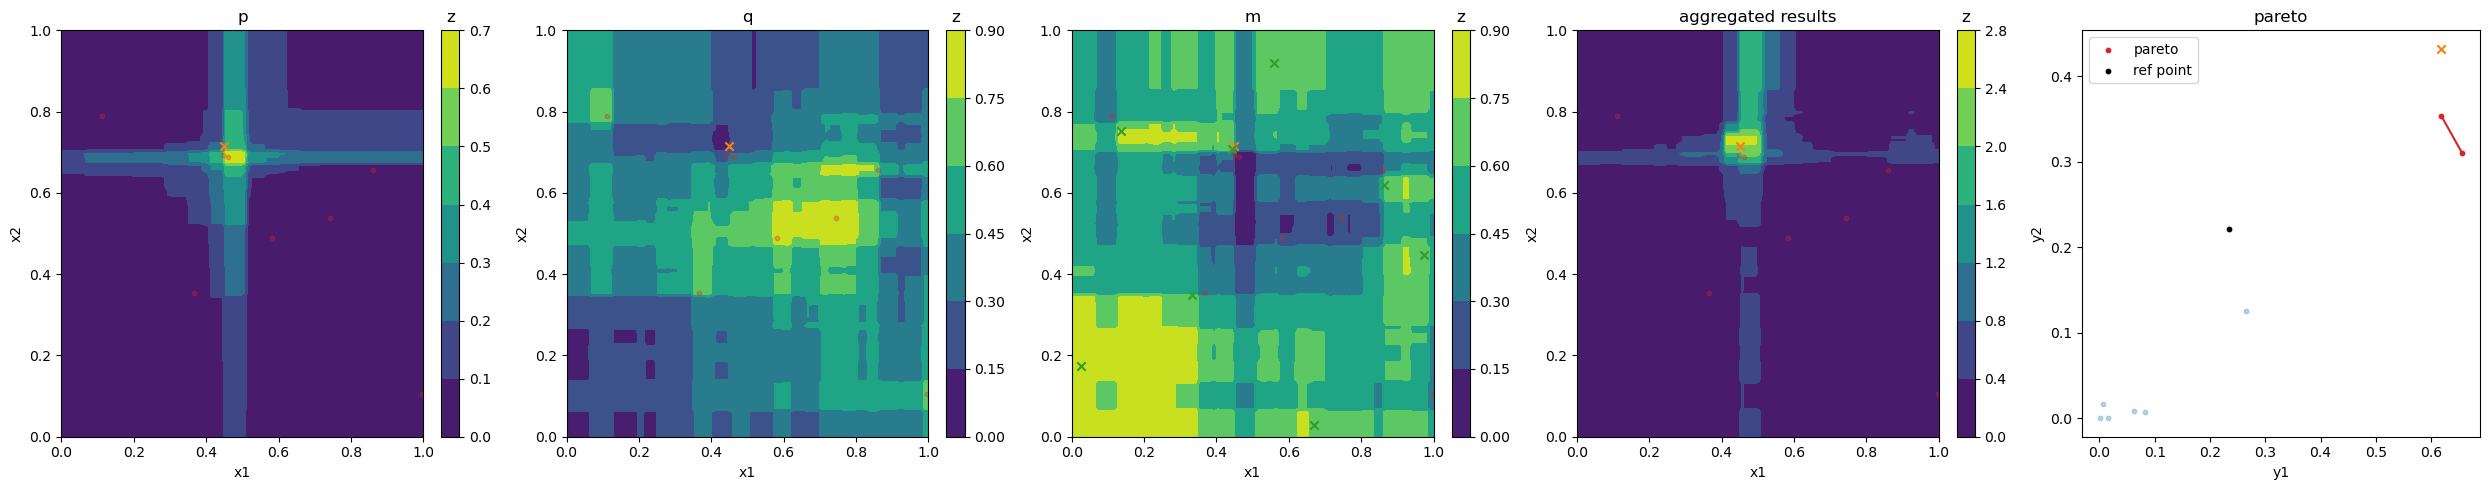

Iteration 3


100%|██████████| 1000/1000 [00:01<00:00, 602.99it/s]
2024-06-03 22:55:22,284 | Model fitting takes 2.27s
2024-06-03 22:55:22,371 | Optimizing the acquisition function takes 0.09s


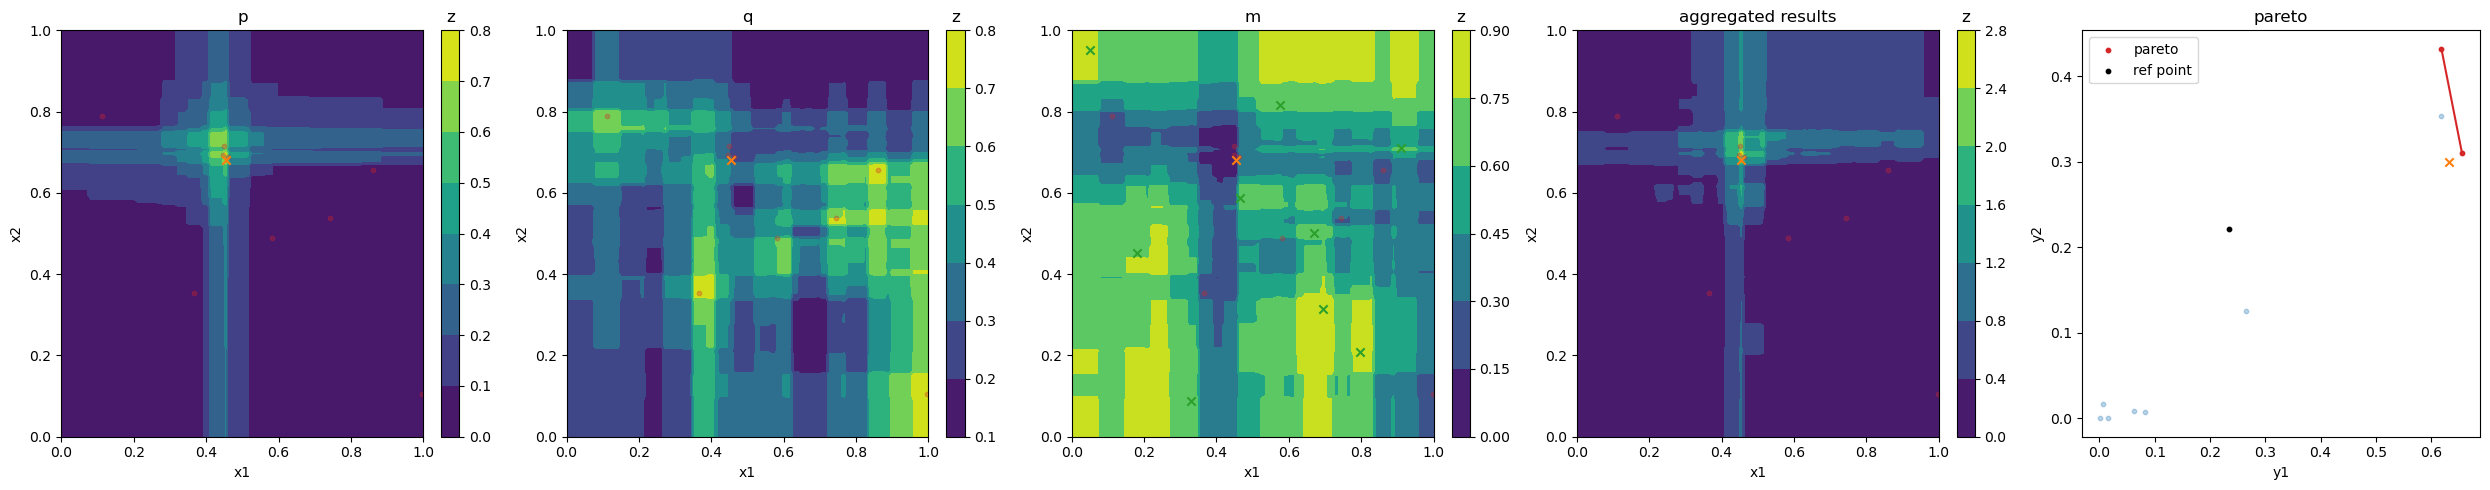

Iteration 4


100%|██████████| 1000/1000 [00:01<00:00, 611.93it/s]
2024-06-03 22:55:25,594 | Model fitting takes 2.29s
2024-06-03 22:55:25,671 | Optimizing the acquisition function takes 0.08s


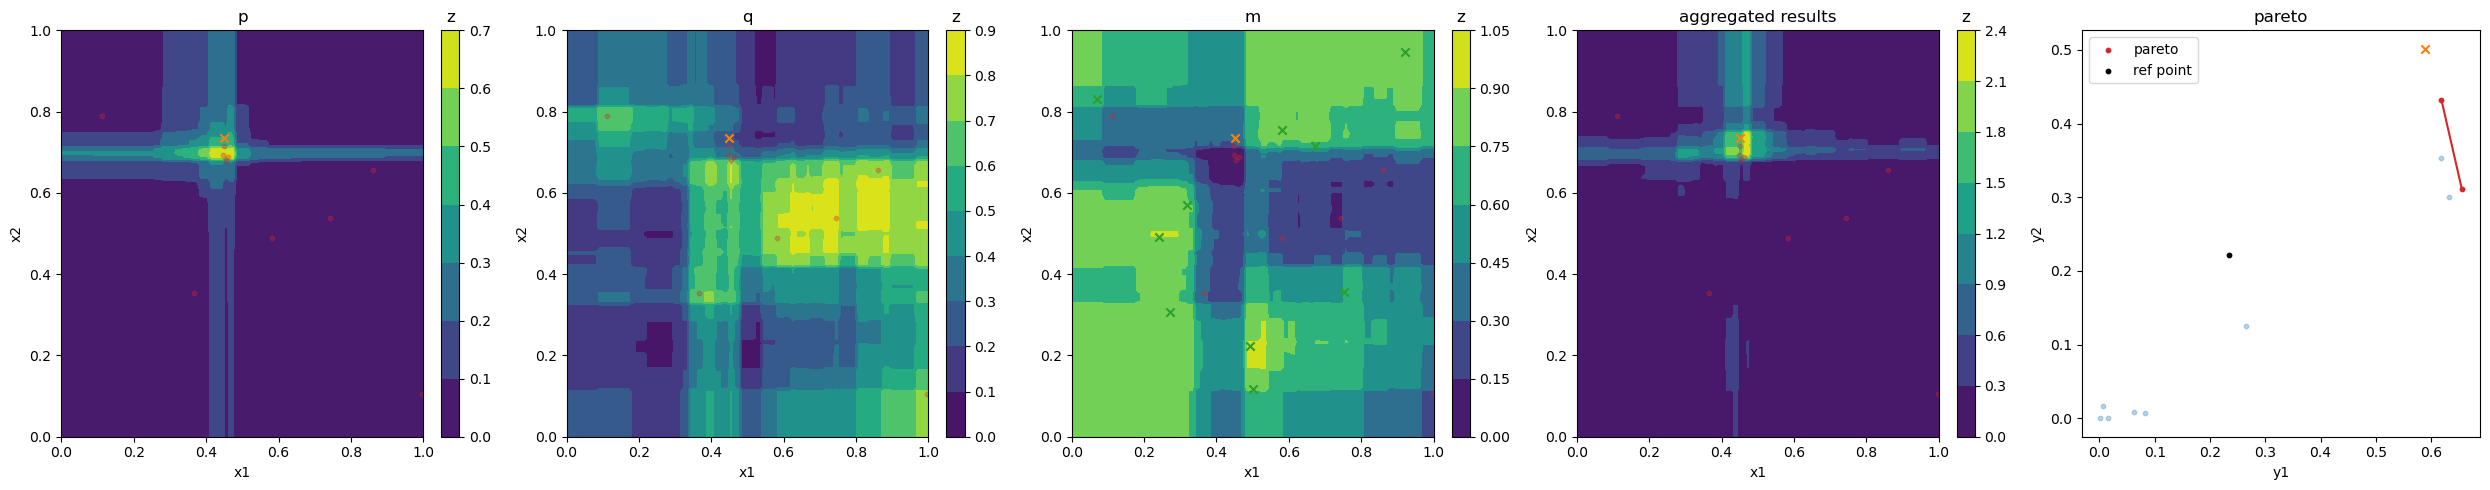

Iteration 5


100%|██████████| 1000/1000 [00:01<00:00, 601.19it/s]
2024-06-03 22:55:29,184 | Model fitting takes 2.29s
2024-06-03 22:55:29,268 | Optimizing the acquisition function takes 0.08s


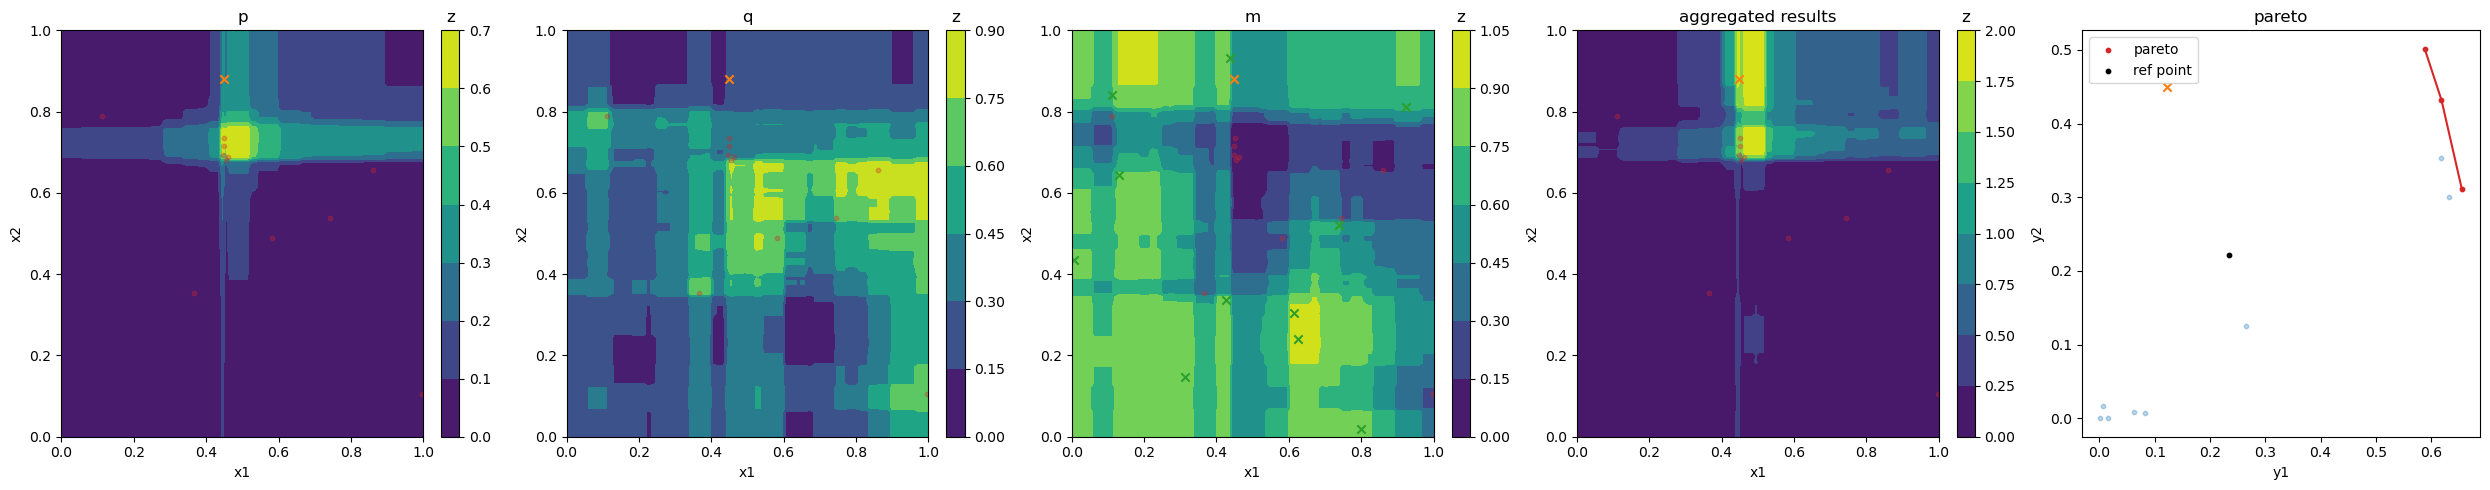

Iteration 6


100%|██████████| 1000/1000 [00:01<00:00, 581.41it/s]
2024-06-03 22:55:32,547 | Model fitting takes 2.32s
2024-06-03 22:55:32,632 | Optimizing the acquisition function takes 0.08s


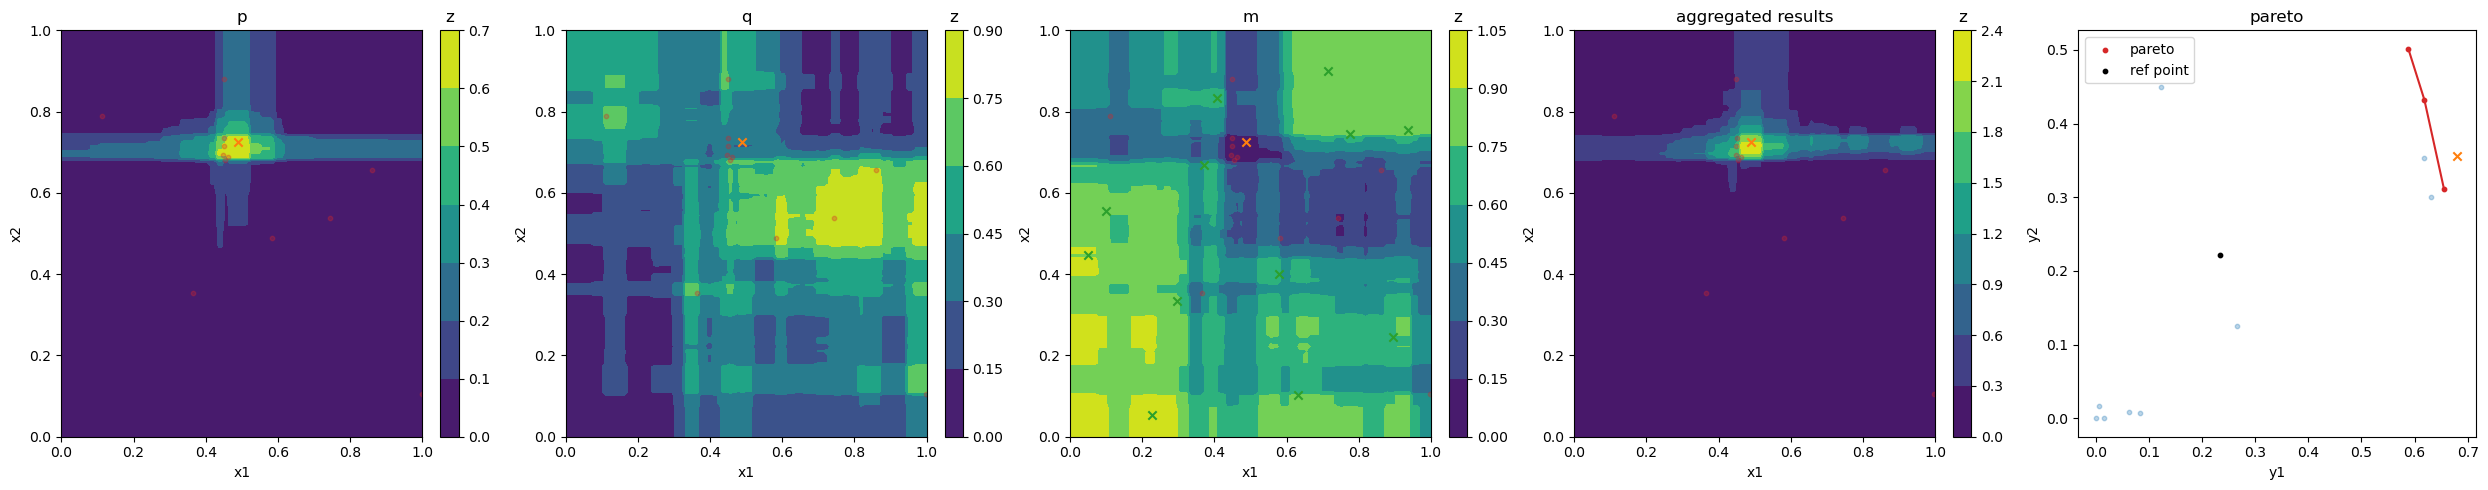

Iteration 7


100%|██████████| 1000/1000 [00:01<00:00, 575.01it/s]
2024-06-03 22:55:35,990 | Model fitting takes 2.33s
2024-06-03 22:55:36,074 | Optimizing the acquisition function takes 0.08s


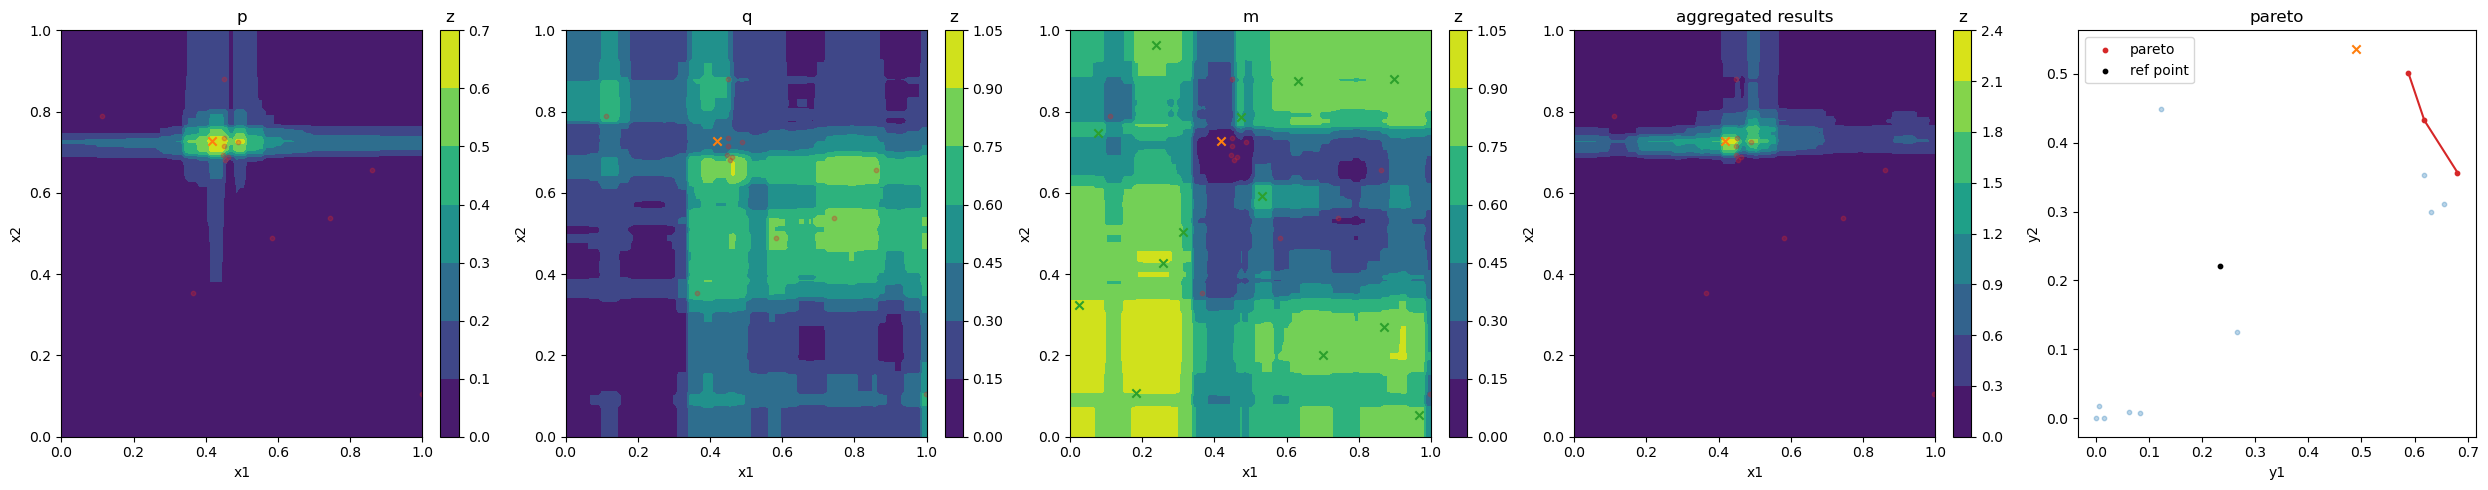

Iteration 8


100%|██████████| 1000/1000 [00:01<00:00, 574.65it/s]
2024-06-03 22:55:39,362 | Model fitting takes 2.33s
2024-06-03 22:55:39,441 | Optimizing the acquisition function takes 0.08s


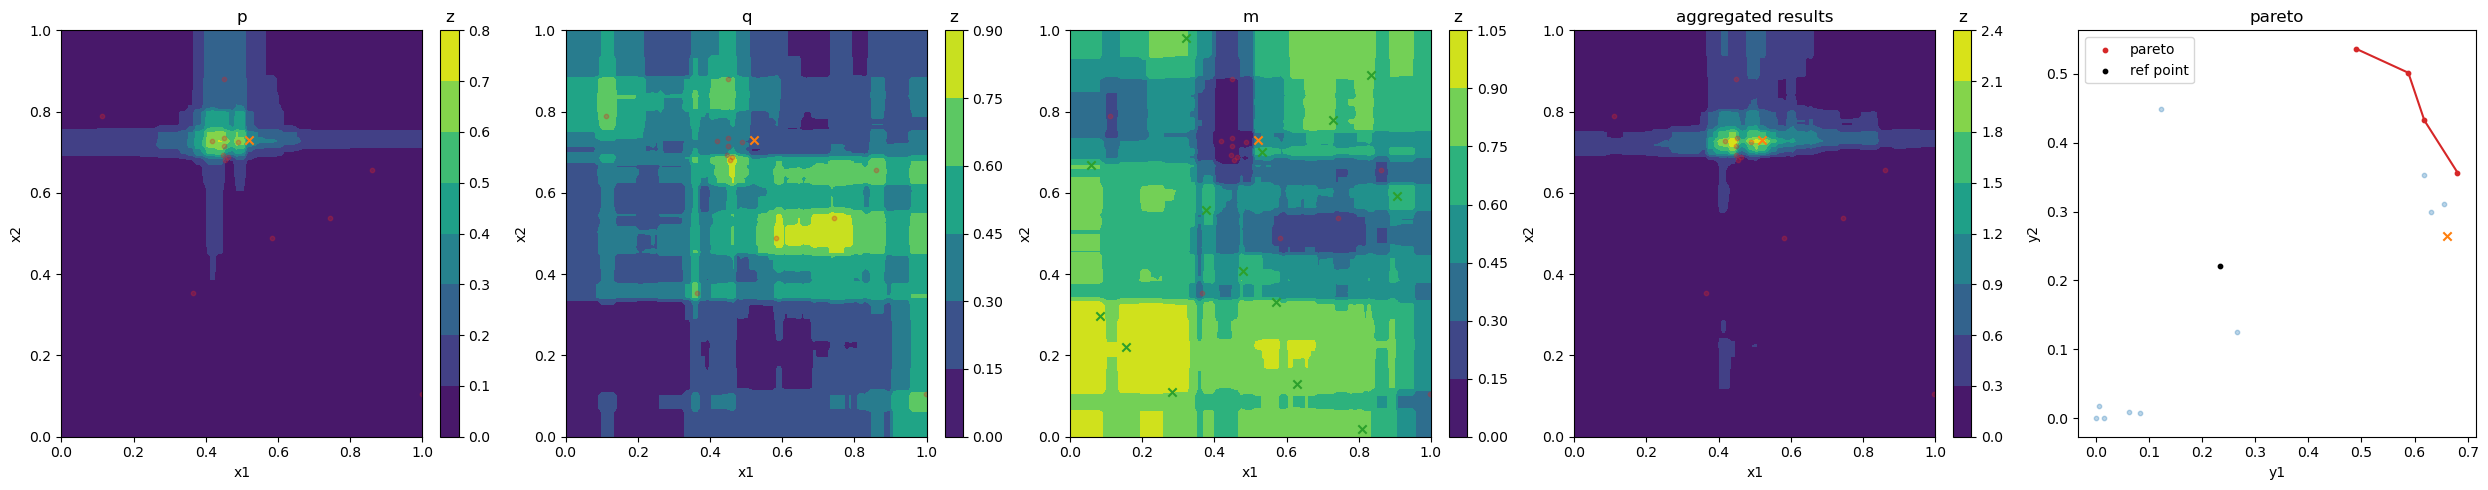

Iteration 9


100%|██████████| 1000/1000 [00:01<00:00, 585.22it/s]
2024-06-03 22:55:42,895 | Model fitting takes 2.30s
2024-06-03 22:55:42,974 | Optimizing the acquisition function takes 0.08s


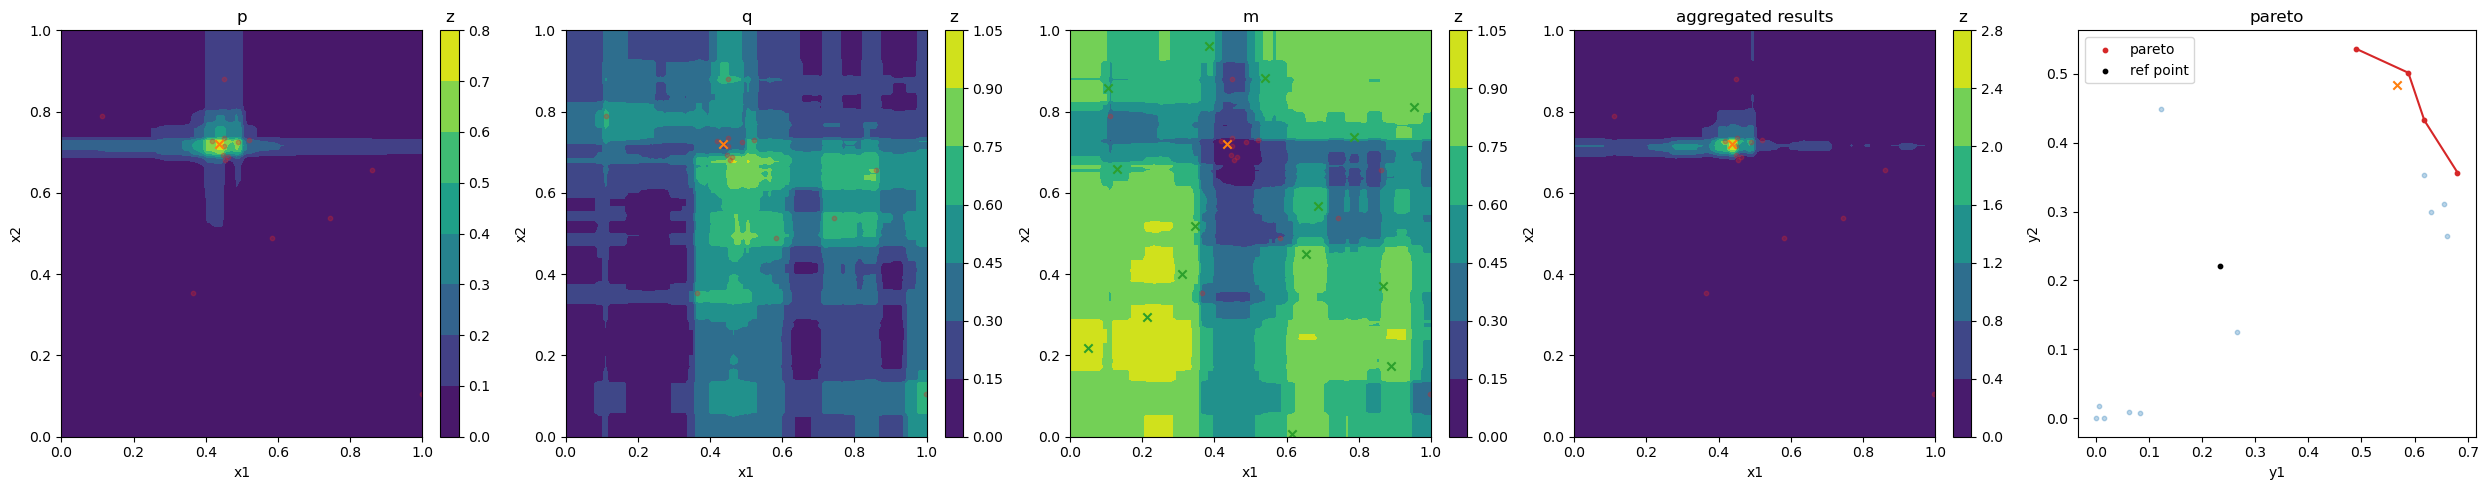

Iteration 10


100%|██████████| 1000/1000 [00:01<00:00, 588.77it/s]
2024-06-03 22:55:46,226 | Model fitting takes 2.28s
2024-06-03 22:55:46,308 | Optimizing the acquisition function takes 0.08s


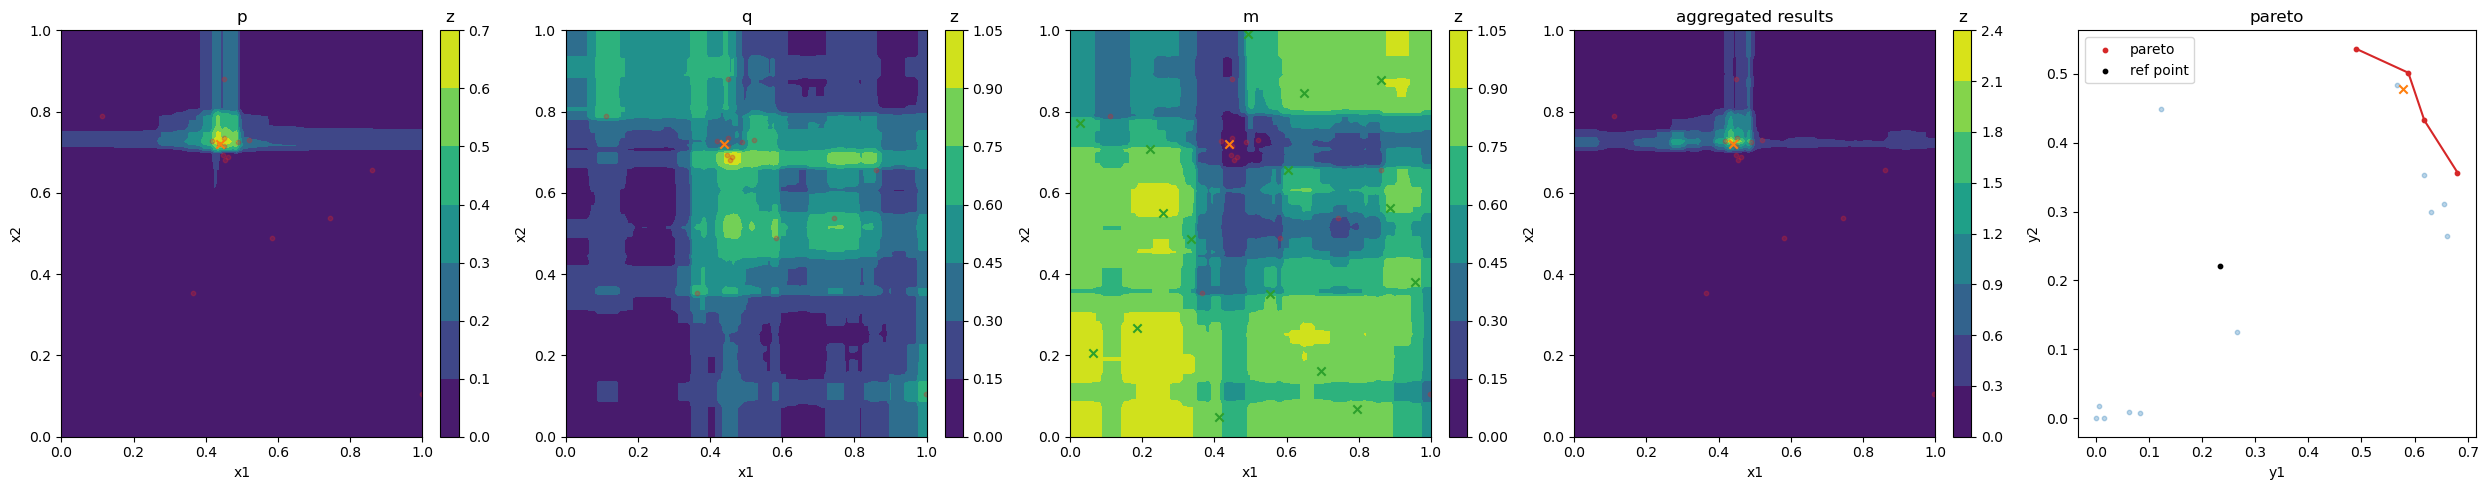

Iteration 11


100%|██████████| 1000/1000 [00:02<00:00, 371.80it/s]
2024-06-03 22:55:50,950 | Model fitting takes 3.66s
2024-06-03 22:55:51,080 | Optimizing the acquisition function takes 0.13s


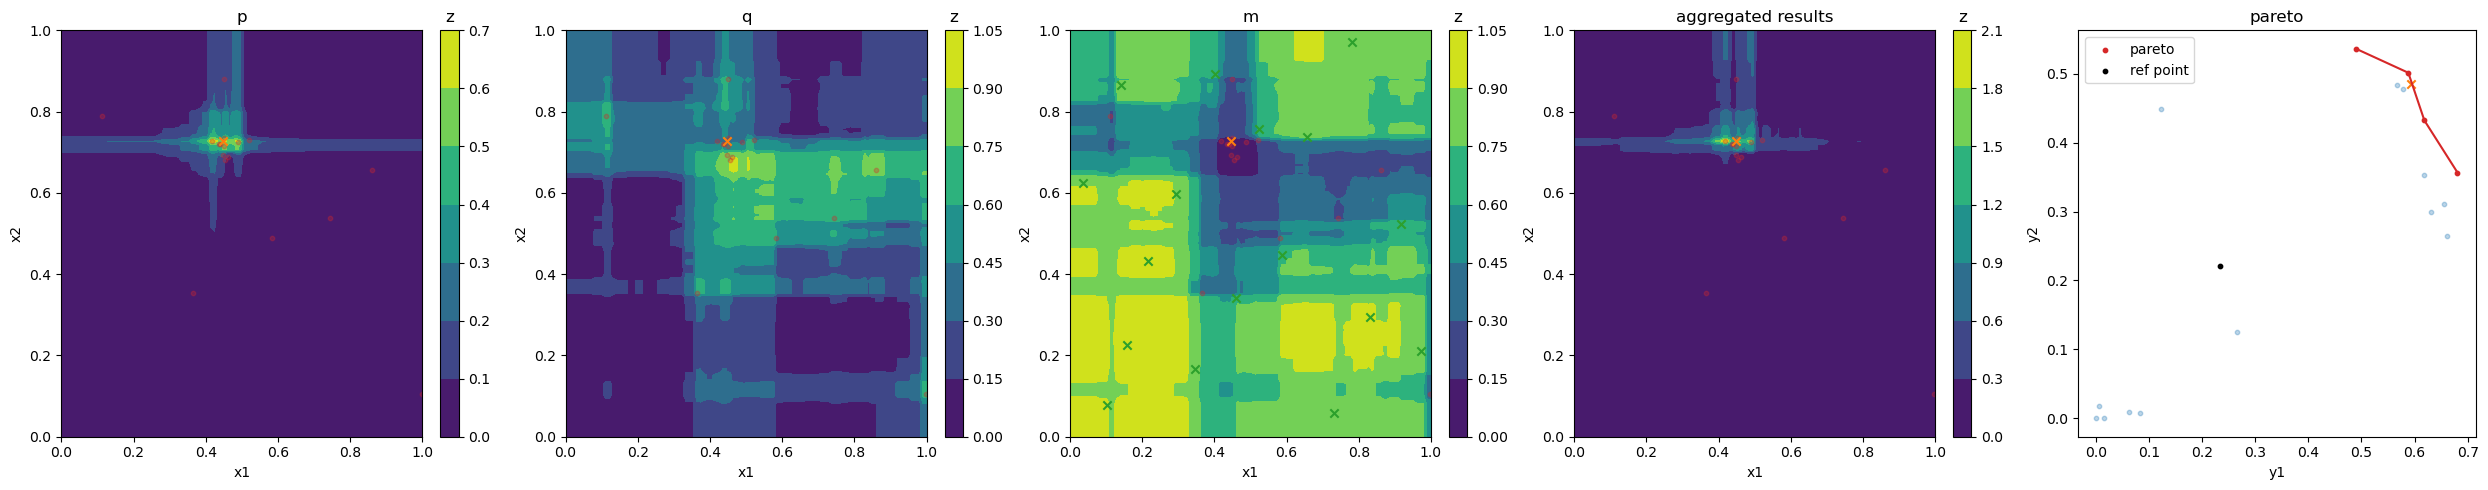

Iteration 12


100%|██████████| 1000/1000 [00:03<00:00, 314.17it/s]
2024-06-03 22:55:56,885 | Model fitting takes 4.24s
2024-06-03 22:55:57,035 | Optimizing the acquisition function takes 0.15s


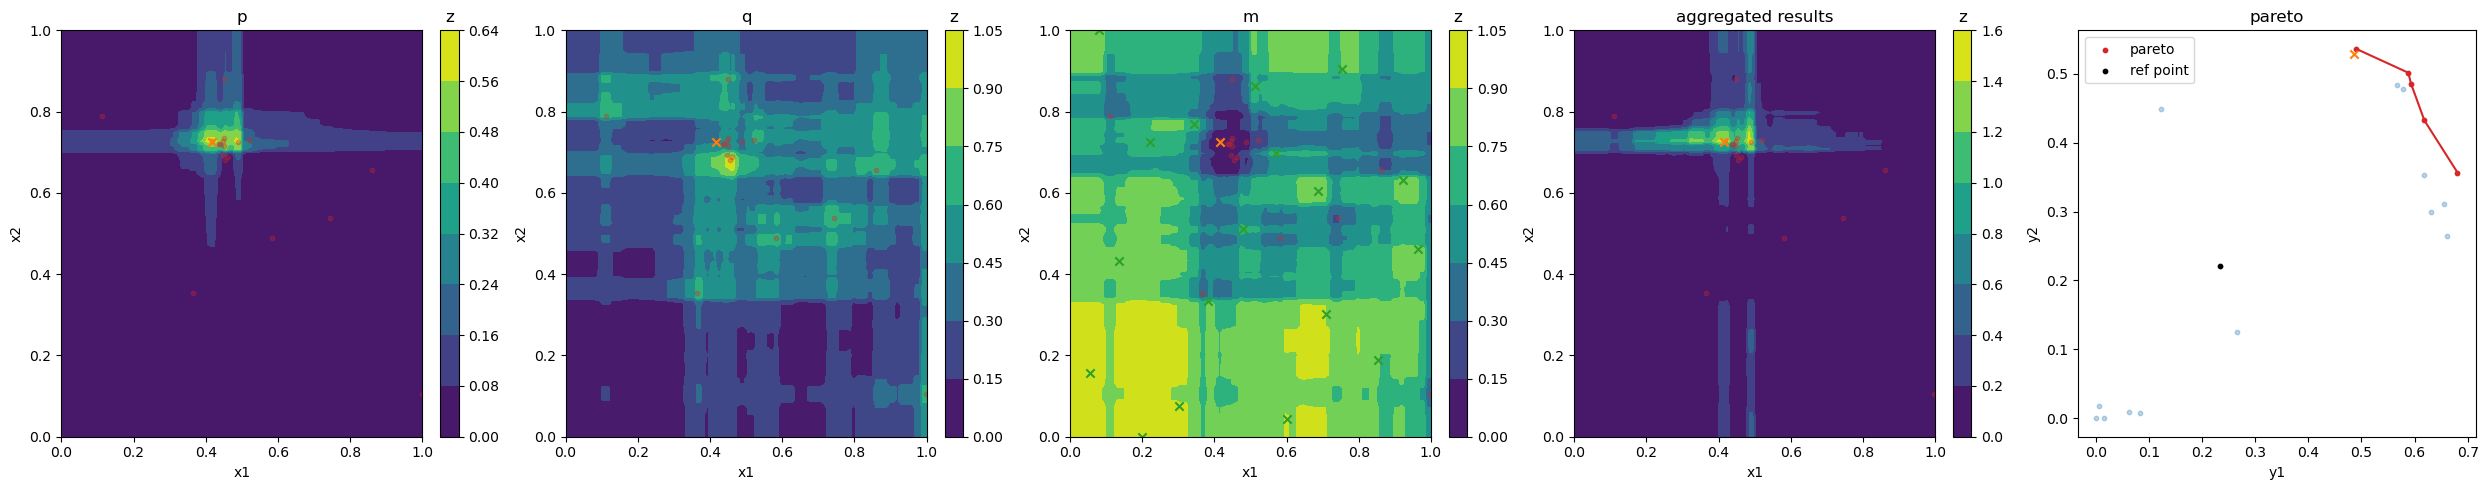

Iteration 13


100%|██████████| 1000/1000 [00:03<00:00, 310.12it/s]
2024-06-03 22:56:02,787 | Model fitting takes 4.17s
2024-06-03 22:56:02,917 | Optimizing the acquisition function takes 0.13s


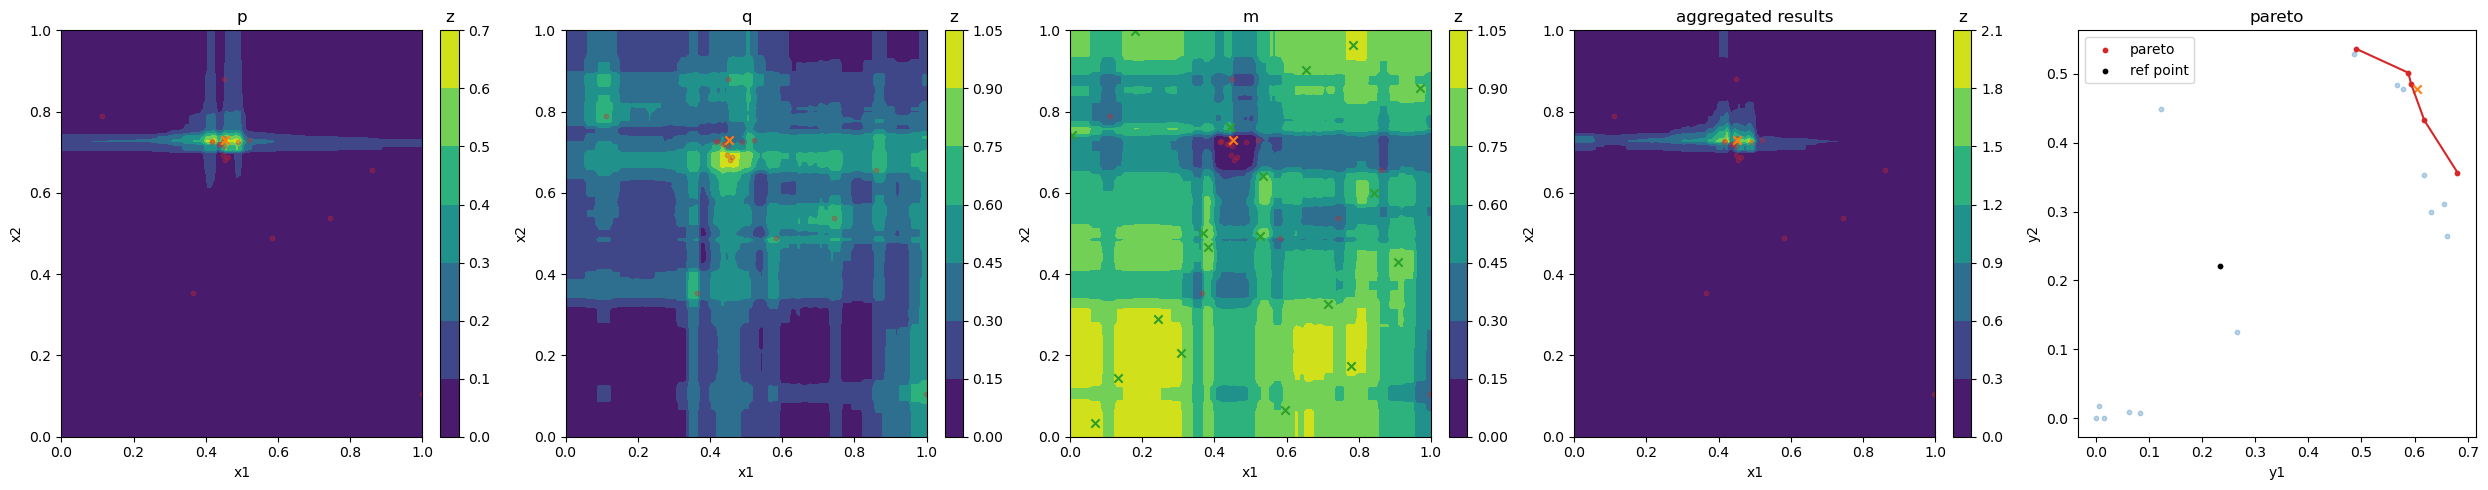

Iteration 14


100%|██████████| 1000/1000 [00:03<00:00, 331.64it/s]
2024-06-03 22:56:08,369 | Model fitting takes 3.96s
2024-06-03 22:56:08,485 | Optimizing the acquisition function takes 0.11s


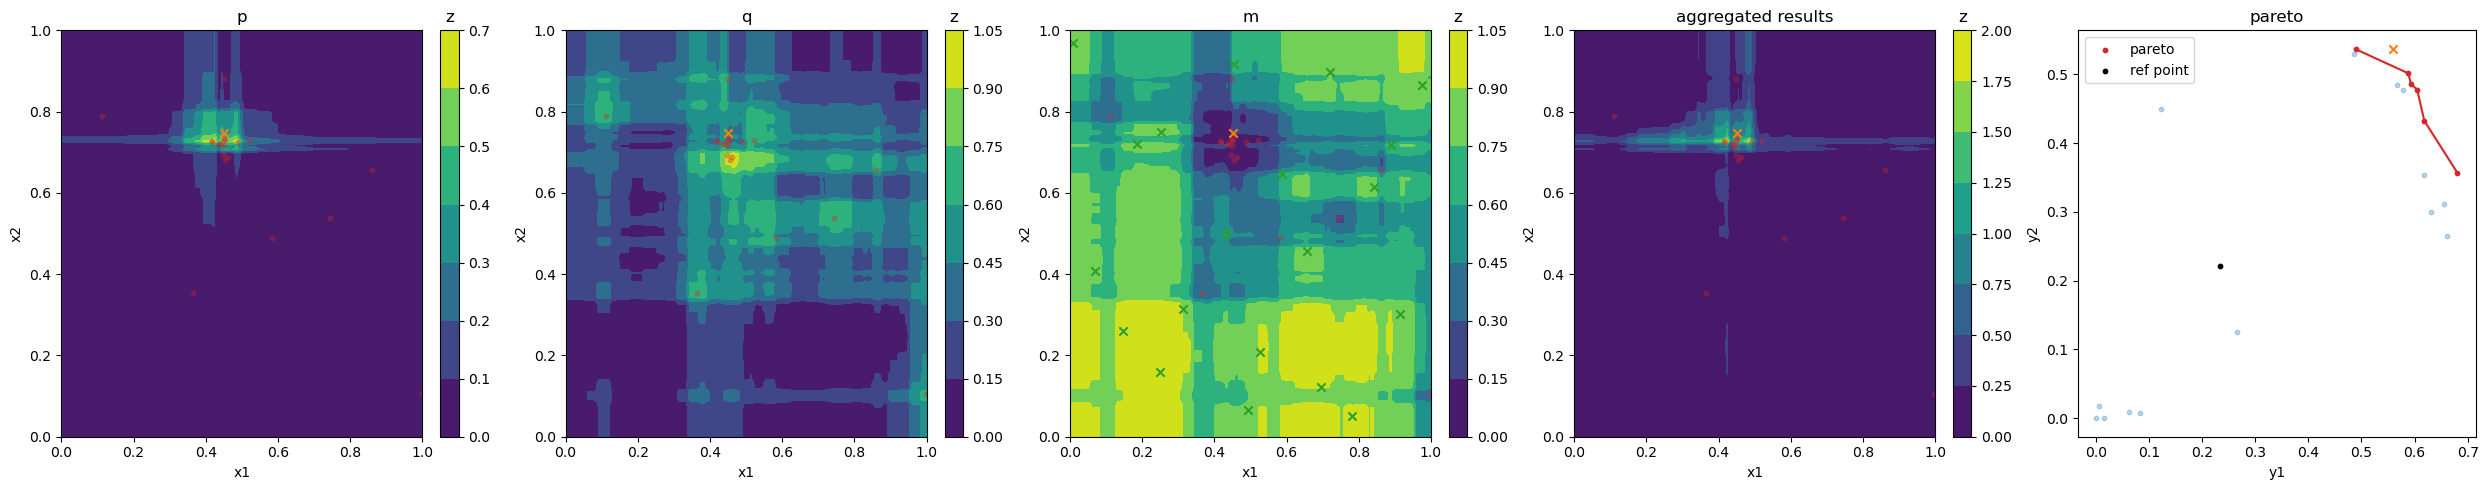

Iteration 15


100%|██████████| 1000/1000 [00:03<00:00, 310.93it/s]
2024-06-03 22:56:14,322 | Model fitting takes 4.20s
2024-06-03 22:56:14,483 | Optimizing the acquisition function takes 0.16s


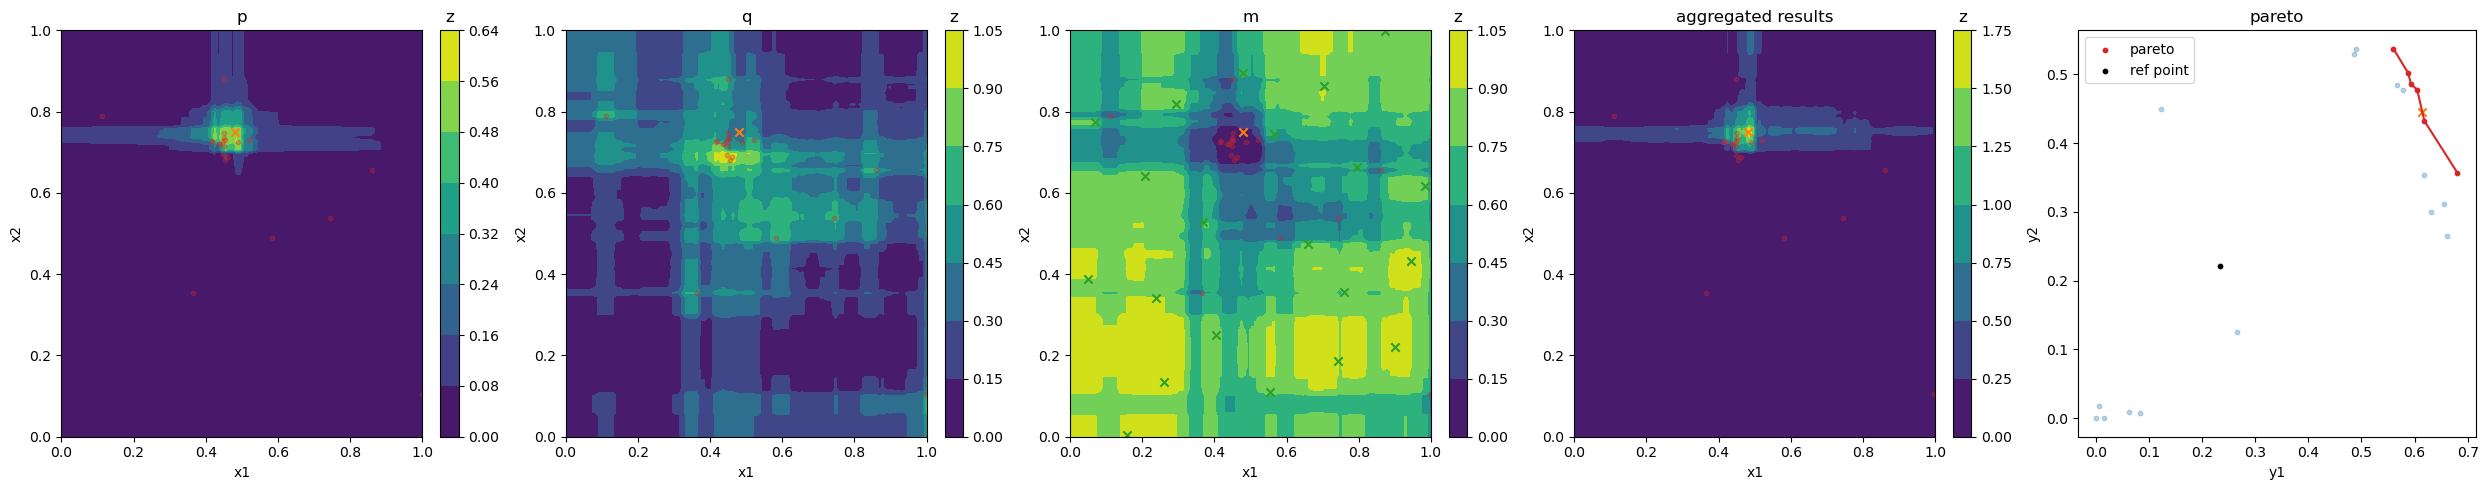

Iteration 16


100%|██████████| 1000/1000 [00:04<00:00, 241.75it/s]
2024-06-03 22:56:21,609 | Model fitting takes 5.39s
2024-06-03 22:56:21,762 | Optimizing the acquisition function takes 0.15s


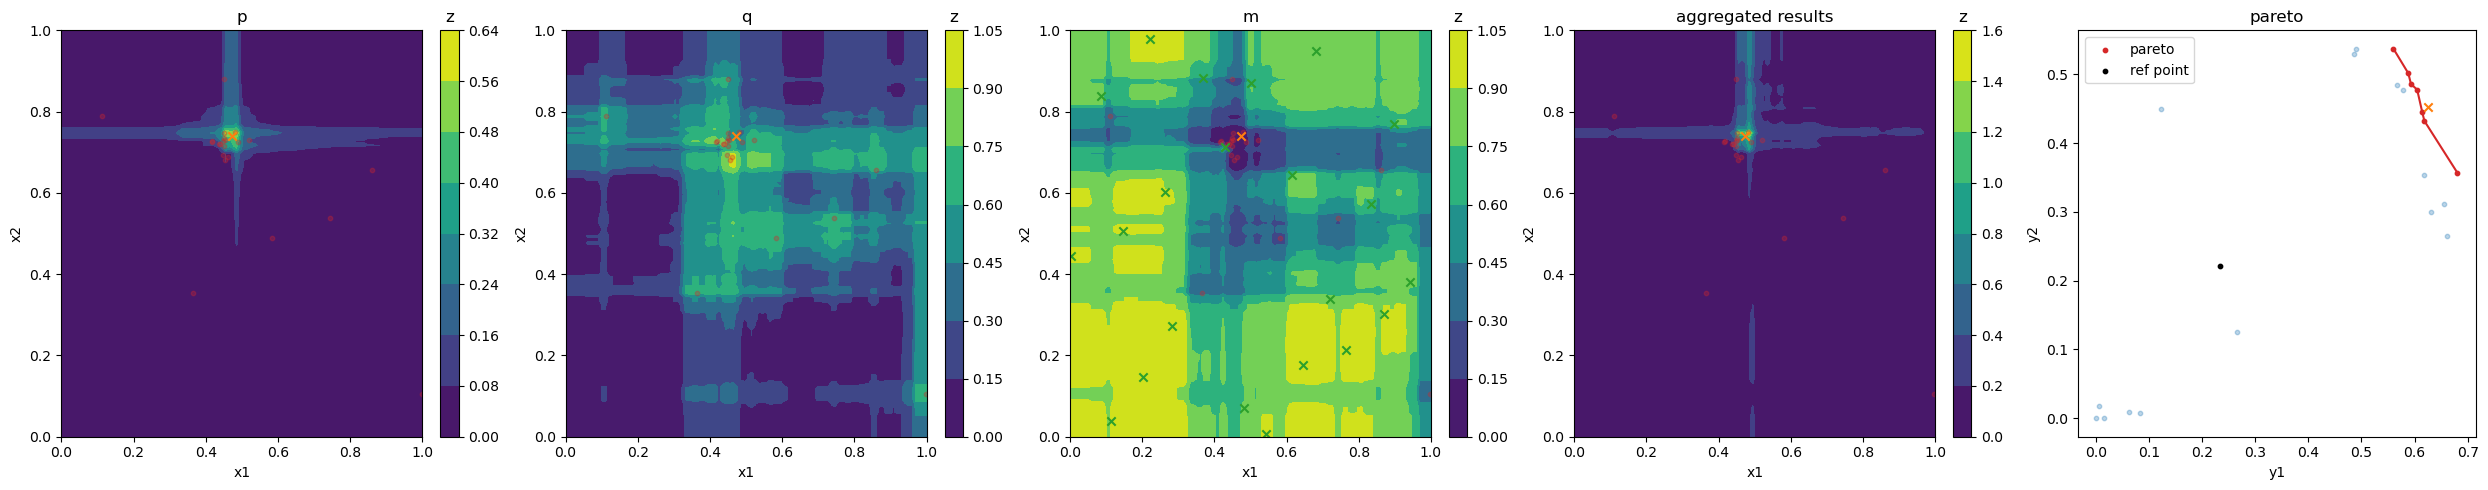

Iteration 17


100%|██████████| 1000/1000 [00:04<00:00, 223.61it/s]
2024-06-03 22:56:30,441 | Model fitting takes 6.03s
2024-06-03 22:56:30,628 | Optimizing the acquisition function takes 0.19s


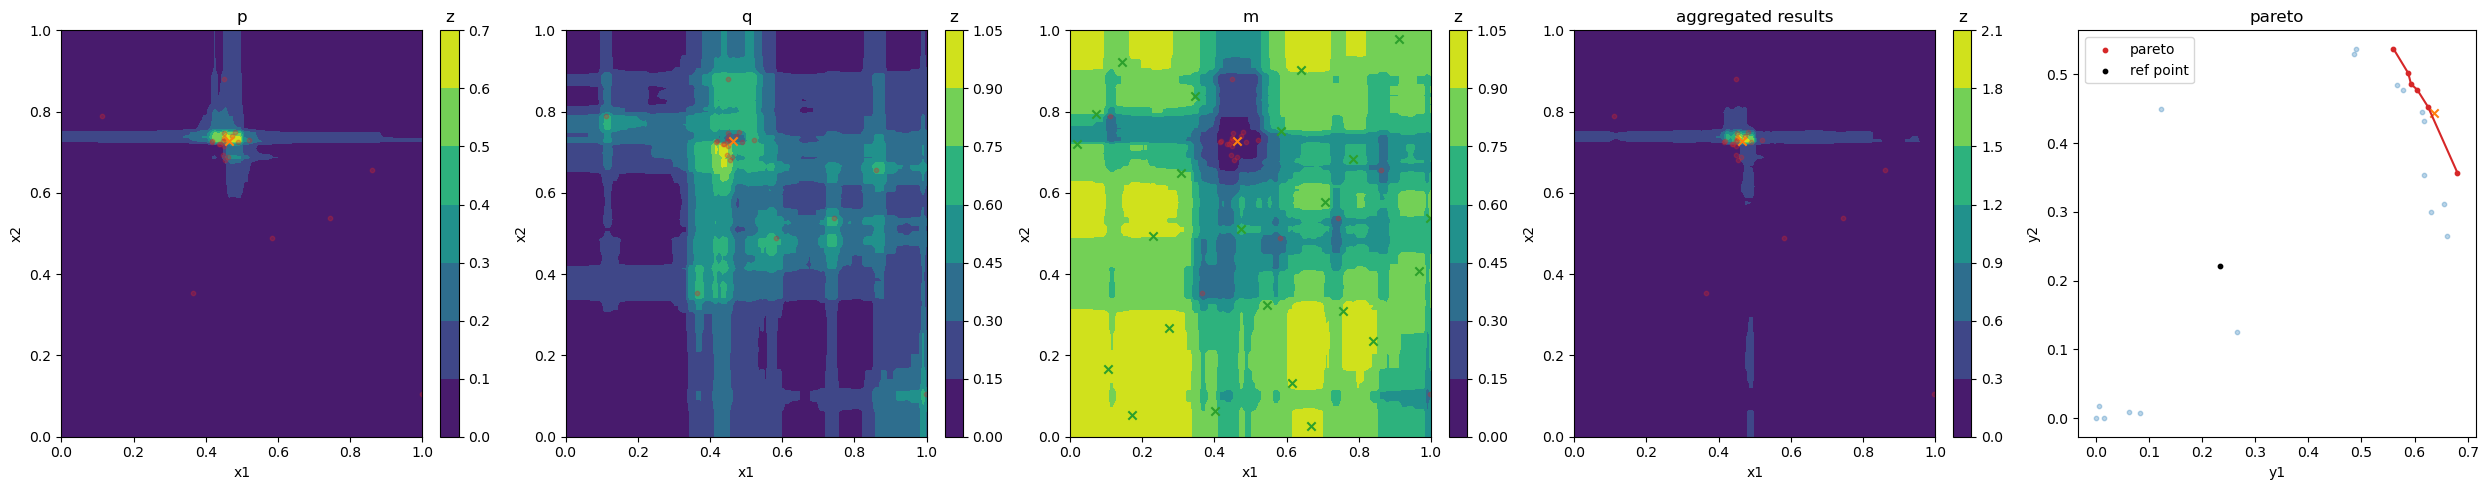

Iteration 18


100%|██████████| 1000/1000 [00:03<00:00, 286.36it/s]
2024-06-03 22:56:37,316 | Model fitting takes 4.62s
2024-06-03 22:56:37,482 | Optimizing the acquisition function takes 0.16s


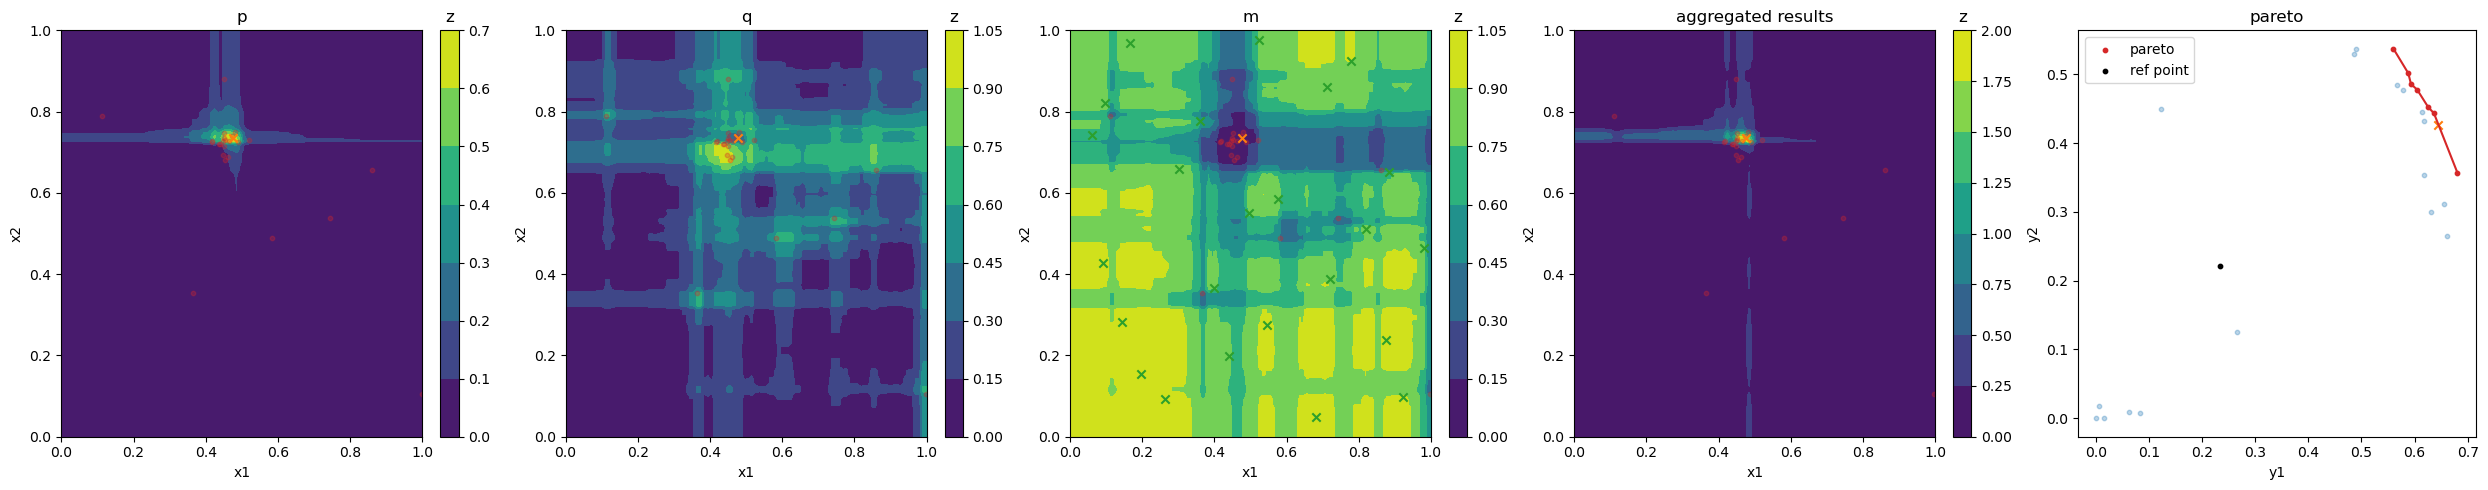

Iteration 19


100%|██████████| 1000/1000 [00:03<00:00, 303.69it/s]
2024-06-03 22:56:43,456 | Model fitting takes 4.38s
2024-06-03 22:56:43,608 | Optimizing the acquisition function takes 0.15s


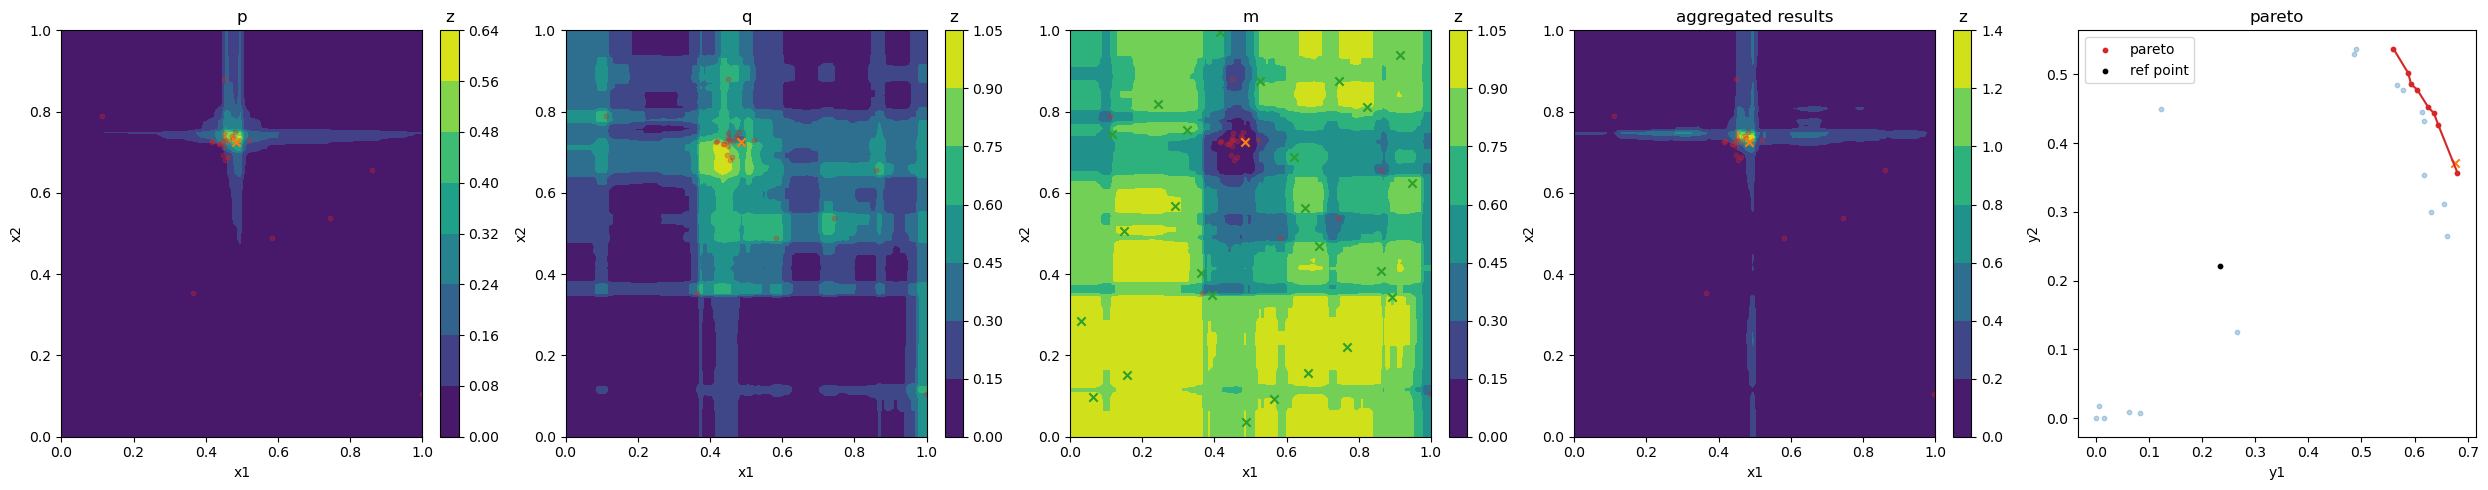

In [10]:
optimizer = MBORE_MDRE_EI_RF_AUX(
    problem=problem, 
)

for n in range(20):
    print(f"Iteration {n}")

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]


    new_x = optimizer.observe_and_suggest(x_obs, y_obs, S=1000)
    new_y = problem(new_x)

    preds_p = torch.empty(0, **tkwargs)
    preds_q = torch.empty(0, **tkwargs)
    preds_m = torch.empty(0, **tkwargs)
    preds = torch.empty(0, **tkwargs)
    i = 0

    with torch.no_grad():
        # MLP
        # pred_logits = optimizer.clf(x_cands)
        # acf_mdre = torch.nn.functional.softmax(pred_logits, dim=-1)
    
        # random forest
        acf_mdre = np.clip(optimizer.clf.predict_proba(x_cands), a_min=1e-4, a_max=None)
        acf_mdre = torch.from_numpy(acf_mdre).to(**tkwargs)

        dr_mdre = acf_mdre[:, 0] / acf_mdre[:, 1]
        preds = torch.cat([preds, dr_mdre])
        preds_p = torch.cat([preds_p, acf_mdre[:, 0]])
        preds_q = torch.cat([preds_q, acf_mdre[:, 1]])
        preds_m = torch.cat([preds_m, acf_mdre[:, 2]])

    # plot aggregated results
    fig = plt.figure(figsize=(25, 5))

    ax_p = plt.subplot2grid((1, 5), (0, 0))
    plot_input_space(xx, yy, x_obs, preds_p, fig, ax_p, title="p")
    ax_p.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_q = plt.subplot2grid((1, 5), (0, 1))
    plot_input_space(xx, yy, x_obs, preds_q, fig, ax_q, title="q")
    ax_q.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m = plt.subplot2grid((1, 5), (0, 2))
    plot_input_space(xx, yy, x_obs, preds_m, fig, ax_m, title="m")
    ax_m.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m.scatter(*optimizer.x_m.t(), marker='x', color='tab:green', label='candidates')

    ax_agg = plt.subplot2grid((1, 5), (0, 3))
    plot_input_space(xx, yy, x_obs, preds, fig, ax_agg, title="aggregated results")
    ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg_p = plt.subplot2grid((1,  5), (0, 4))
    plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
    ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')

    plt.tight_layout()
    plt.show()
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])